# Parameter sweep for LBI predictor

Load flu tip attributes and final clade frequencies and then calculate the error of an exponential growth model based on just the LBI predictor across a range of predictor coefficients. The goal is to determine the shape of the error function that is exposed to scipy's optimization machinery.

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

%matplotlib inline

plt.style.use("huddlej")

In [46]:
pwd

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses'

In [47]:
sys.path.insert(0, "../src")

In [89]:
from fit_model import ExponentialGrowthModel
from forecast.metrics import mean_absolute_error, sum_of_squared_errors, negative_information_gain, add_pseudocounts_to_frequencies

## Load data

Define the range of possible coefficient values to explore.

In [49]:
coefficients = np.linspace(-3, 3, 21)

In [50]:
delta_time = 1.0
l1_lambda = 0.0

In [51]:
last_timepoint = pd.to_datetime("2016-10-01")

In [52]:
# Load tip attributes.
X = pd.read_csv(
    "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/standardized_tip_attributes.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [53]:
X = X.loc[:, ["strain", "clade_membership", "timepoint", "cTiterSub_x", "lbi", "ep", "ep_x", "ne", "delta_frequency", "frequency"]].copy()

In [54]:
X = X[X["timepoint"] <= last_timepoint]

In [55]:
X.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency
0,A/Aichi/181/2004,e5a7ac4,2004-10-01,0.300196,-0.778522,9,0.717596,6,-0.338172,0.003256
1,A/Aichi/183/2004,e80cc78,2004-10-01,0.300196,-0.728971,10,0.848862,6,-0.106321,0.003087
2,A/Anhui/789/2004,e6b34a5,2004-10-01,-1.075470,-1.088123,11,-1.137201,8,-0.267977,0.003449
3,A/Argentina/126/2004,d22442e,2004-10-01,0.299346,-0.628908,10,0.901770,7,0.005987,0.004187
4,A/Argentina/26/2004,24273f7,2004-10-01,-0.332236,-1.184077,7,0.422939,8,-0.153628,0.002362


In [56]:
X.shape

(7512, 10)

In [57]:
# Load final clade tip frequencies.
final_clade_frequencies = pd.read_csv(
    "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/final_clade_frequencies.tsv",
    sep="\t",
    parse_dates=["initial_timepoint", "final_timepoint"]
)

In [58]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,e5a7ac4,2005-10-01,A/RioGrandeDoSul/290/2005,0.002219
1,2004-10-01,e5a7ac4,2005-10-01,A/Thailand/44/2005,0.000074
2,2004-10-01,e80cc78,2005-10-01,NaN,0.000000
3,2004-10-01,e6b34a5,2005-10-01,NaN,0.000000
4,2004-10-01,d22442e,2005-10-01,NaN,0.000000


In [61]:
y = final_clade_frequencies.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

y = y.rename(
    columns={"initial_timepoint": "timepoint"}
)

y = y[y["timepoint"] <= last_timepoint]

In [62]:
y.head()

,timepoint,clade_membership,frequency
0,2004-10-01,0080654,0.0
1,2004-10-01,00ed6d2,0.0
2,2004-10-01,09e833c,0.0
3,2004-10-01,104f8a1,0.0
4,2004-10-01,11be9cb,0.0


In [63]:
y.groupby("timepoint")["frequency"].sum()

timepoint
2004-10-01    0.964599
2005-04-01    0.998792
2005-10-01    1.000009
2006-04-01    0.999998
2006-10-01    0.999997
2007-04-01    1.000000
2007-10-01    1.000002
2008-04-01    0.999994
2008-10-01    1.000001
2009-04-01    0.999998
2009-10-01    0.996692
2010-04-01    0.999995
2010-10-01    0.999990
2011-04-01    0.991793
2011-10-01    0.991572
2012-04-01    0.999686
2012-10-01    0.995549
2013-04-01    0.999921
2013-10-01    0.999048
2014-04-01    1.000002
2014-10-01    0.999980
2015-04-01    0.000000
2015-10-01    0.000000
Name: frequency, dtype: float64

## Inspect LBI model

In [64]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

Calculate error for an LBI model across all coefficients.

In [65]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

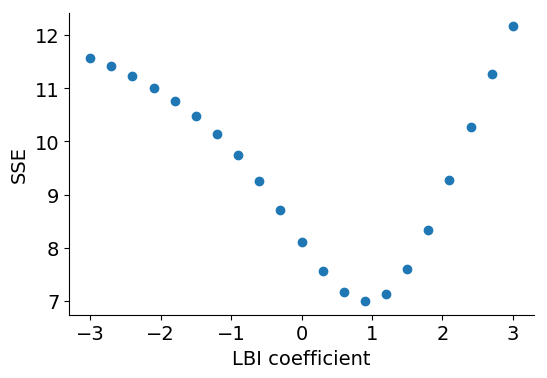

In [66]:
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

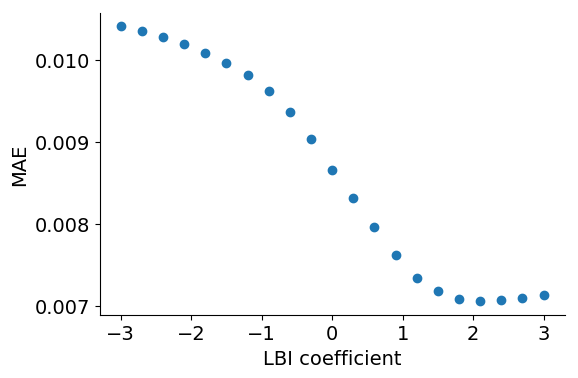

In [67]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("MAE")

## Inspect cTiterSub model

In [68]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [69]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

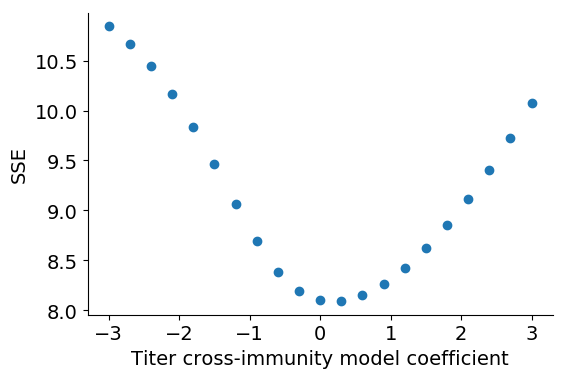

In [70]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

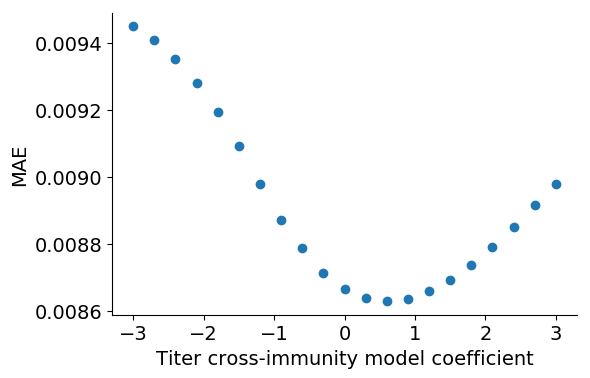

In [71]:
predictors = ["cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Titer cross-immunity model coefficient")
plt.ylabel("MAE")

## Inspect epitope count model

In [72]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [73]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'SSE')

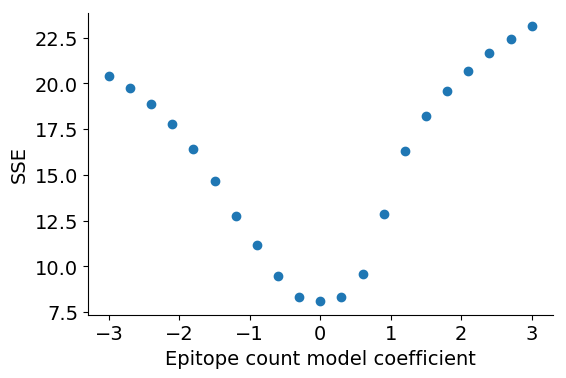

In [74]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

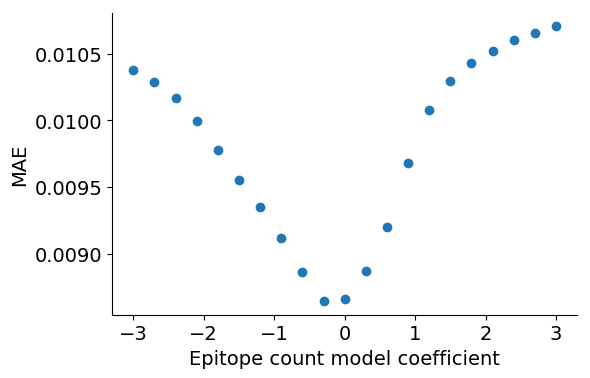

In [75]:
predictors = ["ep"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope count model coefficient")
plt.ylabel("MAE")

## Inspect epitope cross-immunity model

Text(0,0.5,'SSE')

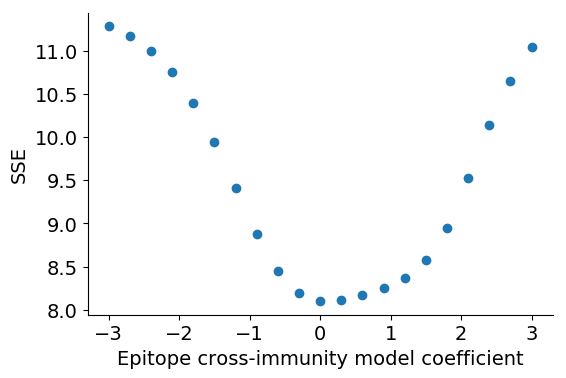

In [76]:
predictors = ["ep_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("SSE")

Text(0,0.5,'MAE')

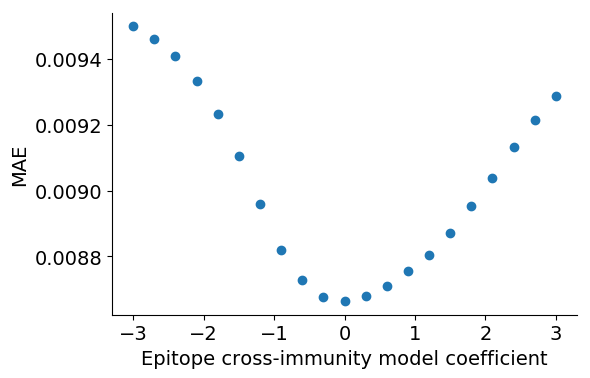

In [77]:
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity model coefficient")
plt.ylabel("MAE")

## Inspect delta frequency model

In [78]:
predictors = ["delta_frequency"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

In [79]:
errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)

Text(0,0.5,'MAE')

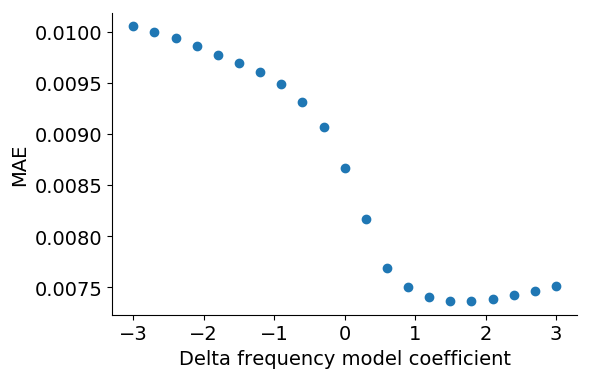

In [80]:
plt.plot(coefficients, errors, "o")
plt.xlabel("Delta frequency model coefficient")
plt.ylabel("MAE")

## Inspect two-parameter models

In [81]:
predictors = ["lbi", "cTiterSub_x"]

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=sum_of_squared_errors
)

In [82]:
len(coefficients)

21

In [83]:
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
    
    errors_by_first_coefficient[coefficient_i] = errors

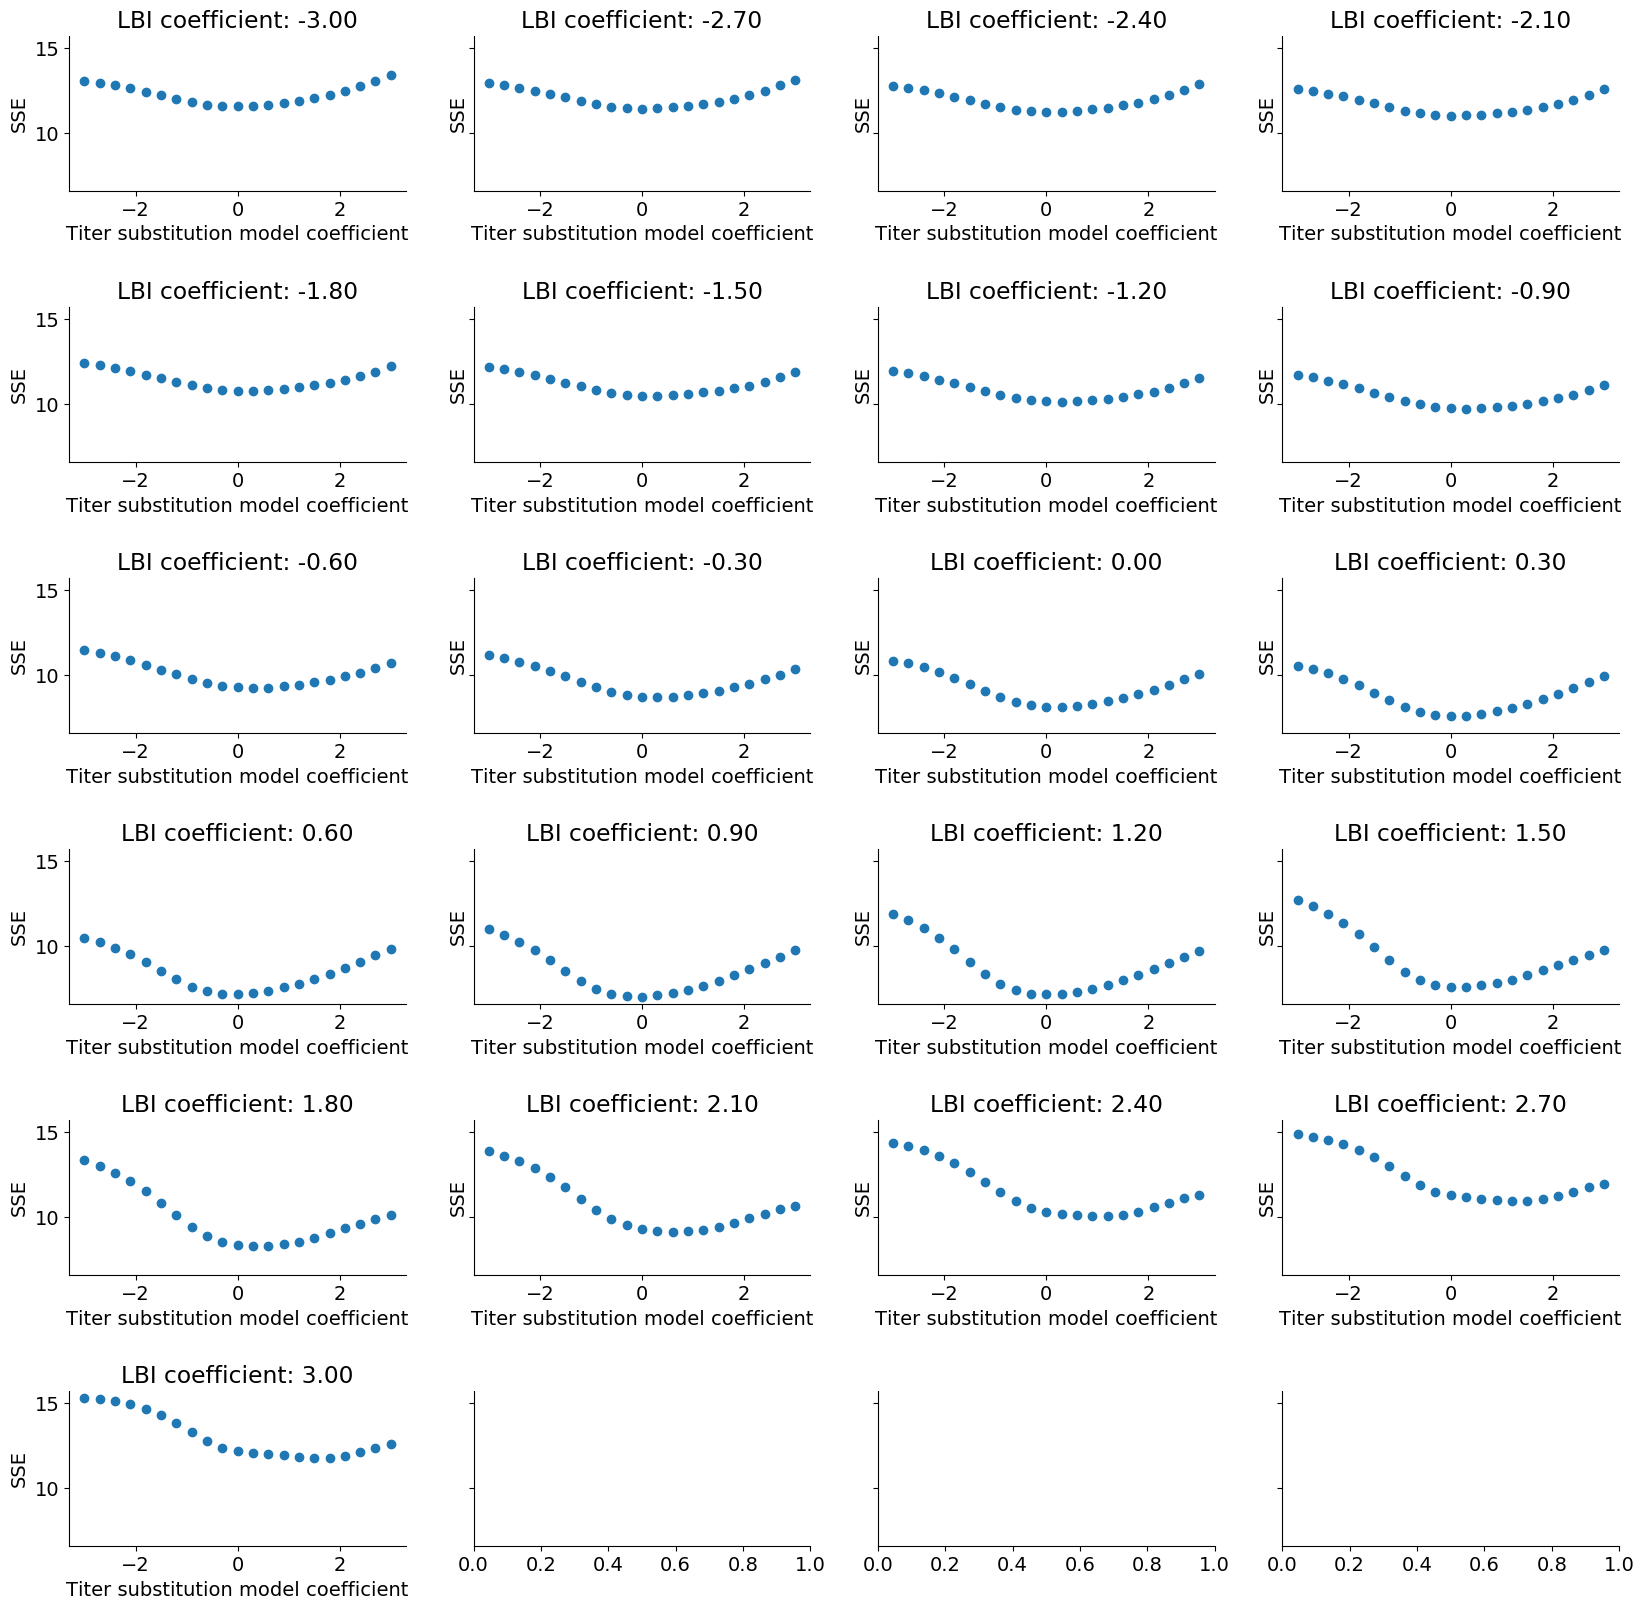

In [84]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("SSE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

In [85]:
predictors = ["lbi", "cTiterSub_x"]
delta_time = 1.0
l1_lambda = 0.0

model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=mean_absolute_error
)

records = []
errors_by_first_coefficient = {}
for coefficient_i in coefficients:
    errors = []
    for coefficient_j in coefficients:
        error = model._fit([coefficient_i, coefficient_j], X, y)
        errors.append(error)
        records.append({
            "lbi": coefficient_i,
            "cTiterSub": coefficient_j,
            "error": error
        })
    
    errors_by_first_coefficient[coefficient_i] = errors

In [86]:
records_df = pd.DataFrame(records)

In [87]:
records_df.sort_values("error").head()

,cTiterSub,error,lbi
367,0.0,0.007063,2.1
388,0.0,0.007078,2.4
387,-0.3,0.007092,2.4
366,-0.3,0.007093,2.1
346,0.0,0.007093,1.8


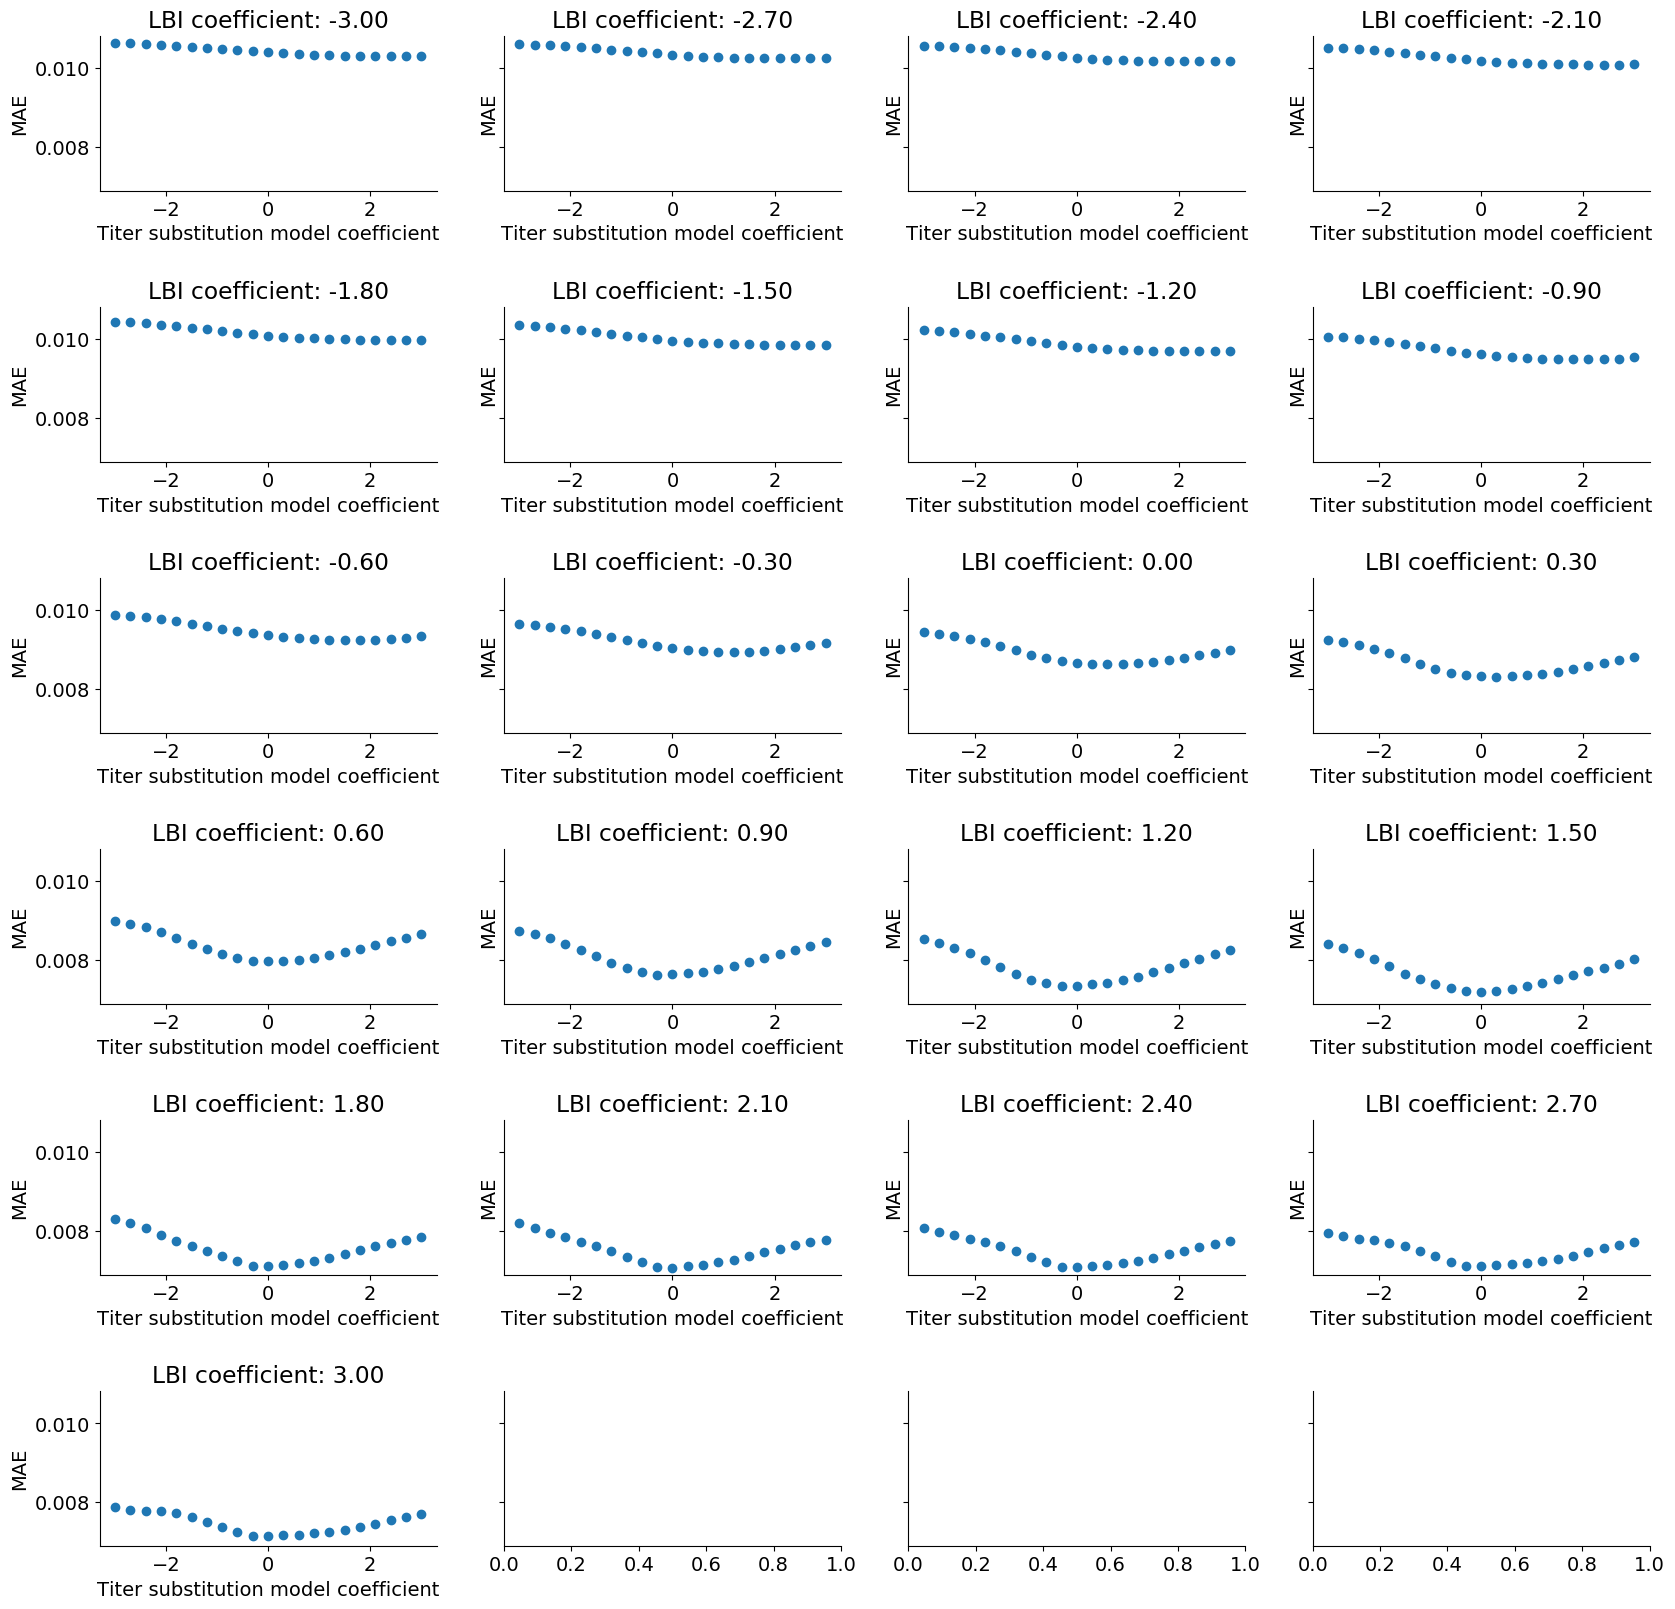

In [88]:
fig, axes = plt.subplots(6, 4, figsize=(20, 20), gridspec_kw={"hspace": 0.75}, sharey=True)

for ci, coefficient_i in enumerate(sorted(errors_by_first_coefficient.keys())):
    ax = axes.flatten()[ci]
    
    errors = errors_by_first_coefficient[coefficient_i]
    ax.plot(coefficients, errors, "o")
    ax.set_xlabel("Titer substitution model coefficient")
    ax.set_ylabel("MAE")
    ax.set_title("LBI coefficient: %.2f" % coefficient_i)

## Minimize negative information gain

Add pseudocounts to current and future tip frequencies.

In [90]:
pseudocount = 1e-3
X_with_pseudocounts = add_pseudocounts_to_frequencies(X, pseudocount)
final_clade_frequencies_with_pseudocounts = add_pseudocounts_to_frequencies(
    final_clade_frequencies,
    pseudocount,
    timepoint_column="initial_timepoint"
)

In [96]:
y_with_pseudocounts = final_clade_frequencies_with_pseudocounts.groupby([
    "initial_timepoint",
    "clade_membership"
])["frequency"].sum().reset_index()

y_with_pseudocounts = y_with_pseudocounts.rename(
    columns={"initial_timepoint": "timepoint"}
)

#y_with_pseudocounts = y_with_pseudocounts[y_with_pseudocounts["timepoint"] <= last_timepoint]

In [91]:
X_with_pseudocounts.head()

,strain,clade_membership,timepoint,cTiterSub_x,lbi,ep,ep_x,ne,delta_frequency,frequency
0,A/Aichi/181/2004,e5a7ac4,2004-10-01,0.300196,-0.778522,9,0.717596,6,-0.338172,0.002981
1,A/Austria/142030/2004,e5a7ac4,2004-10-01,-1.075470,-0.165287,9,-1.137201,6,-0.338172,0.005018
2,A/Bangkok/1158/2004,e5a7ac4,2004-10-01,-1.075470,-0.973485,9,-1.137201,6,-0.338172,0.000831
3,A/ElSalvador/43/2004,e5a7ac4,2004-10-01,0.300196,-0.711333,9,0.717596,6,-0.338172,0.006576
4,A/Hanoi/HN30137/2004,e5a7ac4,2004-10-01,-1.075470,-0.908183,9,-1.137201,6,-0.338172,0.000136


In [93]:
final_clade_frequencies.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,e5a7ac4,2005-10-01,A/RioGrandeDoSul/290/2005,0.002219
1,2004-10-01,e5a7ac4,2005-10-01,A/Thailand/44/2005,0.000074
2,2004-10-01,e80cc78,2005-10-01,NaN,0.000000
3,2004-10-01,e6b34a5,2005-10-01,NaN,0.000000
4,2004-10-01,d22442e,2005-10-01,NaN,0.000000


In [92]:
final_clade_frequencies_with_pseudocounts.head()

,initial_timepoint,clade_membership,final_timepoint,strain,frequency
0,2004-10-01,e5a7ac4,2005-10-01,A/RioGrandeDoSul/290/2005,0.002542
1,2004-10-01,e5a7ac4,2005-10-01,A/Thailand/44/2005,0.000537
2,2004-10-01,e80cc78,2005-10-01,NaN,0.000935
3,2004-10-01,e6b34a5,2005-10-01,NaN,0.000935
4,2004-10-01,d22442e,2005-10-01,NaN,0.000935


In [97]:
y_with_pseudocounts.head()

,timepoint,clade_membership,frequency
0,2004-10-01,0080654,0.000935
1,2004-10-01,00ed6d2,0.000935
2,2004-10-01,09e833c,0.000935
3,2004-10-01,104f8a1,0.000935
4,2004-10-01,11be9cb,0.000935


Text(0,0.5,'Negative information gain')

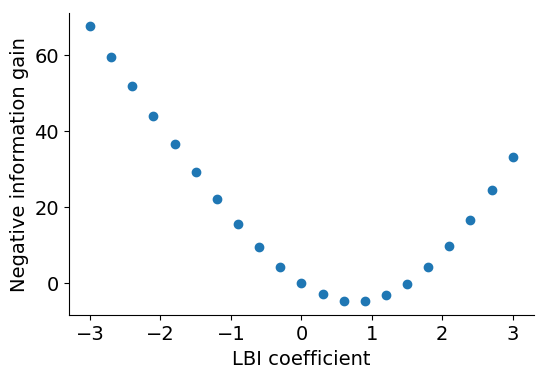

In [98]:
predictors = ["lbi"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X_with_pseudocounts, y_with_pseudocounts)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("LBI coefficient")
plt.ylabel("Negative information gain")

Text(0,0.5,'Negative information gain')

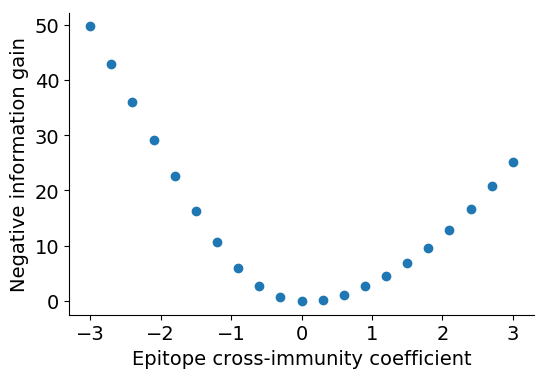

In [99]:
predictors = ["ep_x"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X_with_pseudocounts, y_with_pseudocounts)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity coefficient")
plt.ylabel("Negative information gain")

Text(0,0.5,'Negative information gain')

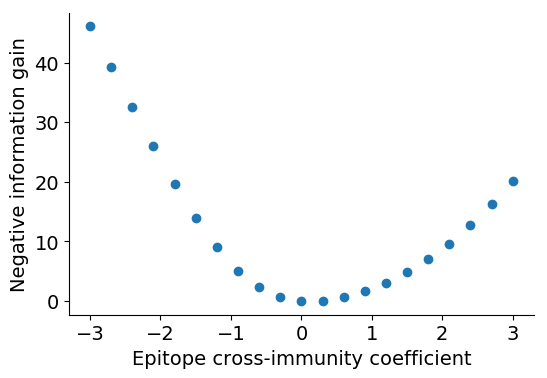

In [100]:
predictors = ["ep_x"]
model = ExponentialGrowthModel(
    predictors=predictors,
    delta_time=delta_time,
    l1_lambda=l1_lambda,
    cost_function=negative_information_gain
)

errors = []
for coefficient in coefficients:
    error = model._fit([coefficient], X, y)
    errors.append(error)
    
plt.plot(coefficients, errors, "o")
plt.xlabel("Epitope cross-immunity coefficient")
plt.ylabel("Negative information gain")